In [1]:
# Author : Martin Thoma 
# URL : https://martin-thoma.com/classify-mnist-with-pybrain/

from struct import unpack
import gzip
import numpy as np
from numpy import zeros, uint8, float32

def get_labeled_data(imagefile, labelfile):
    """Read input-vector (image) and target class (label, 0-9) and return
       it as list of tuples.
    """
    # Open the images with gzip in read binary mode
    images = gzip.open(imagefile, 'rb')
    labels = gzip.open(labelfile, 'rb')

    # Read the binary data

    # We have to get big endian unsigned int. So we need '>I'

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)  # skip the magic_number
    N = labels.read(4)
    N = unpack('>I', N)[0]

    if number_of_images != N:
        raise Exception('number of labels did not match the number of images')

    # Get the data
    x = zeros((N, rows, cols), dtype=float32)  # Initialize numpy array
    y = zeros((N, 1), dtype=uint8)  # Initialize numpy array
    for i in range(N):
        if i % 1000 == 0:
            print("i: %i" % i)
        for row in range(rows):
            for col in range(cols):
                tmp_pixel = images.read(1)  # Just a single byte
                tmp_pixel = unpack('>B', tmp_pixel)[0]
                x[i][row][col] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]
    return (x, y)

x_train, y_train = get_labeled_data("train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz")
x_test, y_test = get_labeled_data("t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz")



i: 0
i: 1000
i: 2000
i: 3000
i: 4000
i: 5000
i: 6000
i: 7000
i: 8000
i: 9000
i: 10000
i: 11000
i: 12000
i: 13000
i: 14000
i: 15000
i: 16000
i: 17000
i: 18000
i: 19000
i: 20000
i: 21000
i: 22000
i: 23000
i: 24000
i: 25000
i: 26000
i: 27000
i: 28000
i: 29000
i: 30000
i: 31000
i: 32000
i: 33000
i: 34000
i: 35000
i: 36000
i: 37000
i: 38000
i: 39000
i: 40000
i: 41000
i: 42000
i: 43000
i: 44000
i: 45000
i: 46000
i: 47000
i: 48000
i: 49000
i: 50000
i: 51000
i: 52000
i: 53000
i: 54000
i: 55000
i: 56000
i: 57000
i: 58000
i: 59000
i: 0
i: 1000
i: 2000
i: 3000
i: 4000
i: 5000
i: 6000
i: 7000
i: 8000
i: 9000


In [ ]:
Preprocessing Part

In [52]:
import copy
import cv2
from pylab import imshow, show, cm


def view_image(image, label=""):
    """View a single image."""
    print("Label: %s" % label)
    imshow(image, cmap=cm.gray)
    show()

    
def threshold(s):
    size = len(s[0])
    ret = copy.deepcopy(s)
    for i in ret:
        for j in range(0, size):
            for k in range(0, size):
                if i[j][k]<128:
                    i[j][k] = 0
                else:
                    i[j][k] = 1
    return ret


def resize(images):
    size = len(images[0])
    image_list = []
    for image in images:
        f_break = False
        for x in range(0, size):
            for y in range(0, size):
                if image[y][x]!=0.0:
                    x_min = x   
                    f_break = True
                    break
            if f_break:
                break

        f_break = False
        for x in range(size-1,-1,-1):
            for y in range(0, size):
                if image[y][x]!=0.0:
                    x_max = x   
                    f_break = True
                    break
            if f_break:
                break

        f_break = False
        for y in range(0, size):
            for x in range(0, size):
                if image[y][x]!=0.0:
                    y_min = y    
                    f_break = True
                    break
            if f_break:
                break

        f_break = False
        for y in range(size-1,-1,-1):
            for x in range(0, size):
                if image[y][x]!=0.0:
                    y_max = y    
                    f_break = True
                    break
            if f_break:
                break

        temp_image = image[y_min: y_max+1]
        new_image = temp_image[..., x_min: x_max+1]
        final_image = cv2.resize(np.asarray(new_image),(20,20))
#         view_image(final_image)
        image_list.append(final_image)
    return np.asarray(image_list)

print("t_x_train = threshold(x_train)")
t_x_train = threshold(x_train)
print("t_x_test = threshold(x_test)")
t_x_test = threshold(x_test)
print("rt_x_train = threshold(resize(x_train))")
rt_x_train = threshold(resize(x_train))
print("rt_x_test = threshold(resize(x_test))")
rt_x_test = threshold(resize(x_test))

t_x_train = threshold(x_train)
t_x_test = threshold(x_test)
rt_x_train = threshold(resize(x_train))
rt_x_test = threshold(resize(x_test))


In [ ]:
Naive Bayes Part

In [71]:
from scipy.stats import norm

def naiveBayesG(train_set, train_labels, test_set, test_labels):
    # return predicted labels of test set
    
    print("calculaing...")
    size = len(train_set[0])
    # index corresponding to each label 
    dict_train_index = {}
    # probability corresponding to each label
    probability = {}
    for i in range(0, 10):
        dict_train_index[i] = list(np.where(np.asarray(train_labels) == i)[0])
        probability[i] = len(dict_train_index[i])/len(train_labels)
        
#     dataset corresponding to each label
    dict_train_set = {}
    for i in range(0, 10):
        dict_train_set[i] = np.asarray([train_set[j] for j in dict_train_index[i]])  
    
#     mean and var for images' features
    mean_list = np.empty([10,size,size])
    var_list = np.empty([10,size,size])
    for i in range(0, 10):  
        for j in range(0, size):
            for k in range(0, size):
                feature_list = []
                for m in range(0, len(dict_train_set[i])):
                    feature_list.append(dict_train_set[i][m][j][k])
                feature_mean = np.mean(feature_list)
                mean_list[i][j][k] = feature_mean
                feature_var = np.var(feature_list)
                var_list[i][j][k] = feature_var
                
# #    view mean image
#     for i in range(0, 10):
#         view_image(mean_list[i], i)
      
 # compare the probability of test set for each label   
    print("comparing...")
    label = []
    count = 0
    for s in test_set:
        count += 1
        if count%500 == 0:
            print(count)
        dict_compare = {}
        for i in range(0, 10):
            dict_compare[i] = np.log(probability[i])
            for j in range(0, size):
                for k in range(0, size):
                    if var_list[i][j][k] != 0:
                        p = norm.pdf(s[j][k], mean_list[i][j][k], np.sqrt(var_list[i][j][k]))
                        if p == 0:
                            p = 1e-15
                        dict_compare[i] += np.log(p)
        label.append(max(dict_compare, key=dict_compare.get))
        
# compute accuracy
    print("computing accuracy...")
    correct = 0
    for i in range(0, len(test_labels)):
        if test_labels[i][0] == label[i]:
            correct += 1
    accuracy = correct/len(test_labels)
    print("Guassian NB accuarcy: ", accuracy)
    



In [72]:
from scipy.stats import norm

def naiveBayesB(train_set, train_labels, test_set, test_labels):
    # return predicted labels of test set
    
    print("calculaing...")
    size = len(train_set[0])
    # index corresponding to each label 
    dict_train_index = {}
    # probability corresponding to each label
    probability = {}
    for i in range(0, 10):
        dict_train_index[i] = list(np.where(np.asarray(train_labels) == i)[0])
        probability[i] = len(dict_train_index[i])/len(train_labels)
        
#     dataset corresponding to each label
    dict_train_set = {}
    for i in range(0, 10):
        dict_train_set[i] = np.asarray([train_set[j] for j in dict_train_index[i]])  
    
#     p for images' features
    p_zero_list = np.empty([10,size,size])
    p_one_list = np.empty([10,size,size])
    for i in range(0, 10):  
        for j in range(0, size):
            for k in range(0, size):
                feature_list = []
                for m in range(0, len(dict_train_set[i])):
                    feature_list.append(dict_train_set[i][m][j][k])  
                p_zero = feature_list.count(0)/len(feature_list)
                p_zero_list[i][j][k] = p_zero
                p_one_list[i][j][k] = 1-p_zero
                
# #    view mean image
#     for i in range(0, 10):
#         view_image(mean_list[i], i)
      
 # compare the probability of test set for each label   
    print("comparing...")
    label = []
    count = 0
    for s in test_set:
        count += 1
        if count%500 == 0:
            print(count)
        dict_compare = {}
        for i in range(0, 10):
            dict_compare[i] = np.log(probability[i])
            for j in range(0, size):
                for k in range(0, size):
                    if s[j][k] == 0:
                        p = p_zero_list[i][j][k]
                    else:
                        p = p_one_list[i][j][k]
                    if p == 0:
                        p = 1e-15
                    dict_compare[i] += np.log(p)
        label.append(max(dict_compare, key=dict_compare.get))
        
# compute accuracy
    print("computing accuracy...")
    correct = 0
    for i in range(0, len(test_labels)):
        if test_labels[i][0] == label[i]:
            correct += 1
    accuracy = correct/len(test_labels)
    print("Bernouilli NB accuarcy: ", accuracy)
    


In [74]:
print("Untouched Guassian: ")
naiveBayesG(t_x_train, y_train, t_x_test, y_test)
print("Resized Guassian: ")
naiveBayesG(rt_x_train, y_train, rt_x_test, y_test)

print("Untouched Bernouilli: ")
naiveBayesB(t_x_train, y_train, t_x_test, y_test)
print("Resized Bernouilli: ")
naiveBayesB(rt_x_train, y_train, rt_x_test, y_test)


Untouched Guassian: 
calculaing...
comparing...
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
computing accuracy...
Guassian NB accuarcy:  0.7805
Resized Guassian: 
calculaing...
comparing...
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
computing accuracy...
Guassian NB accuarcy:  0.8207
Untouched Bernouilli: 
calculaing...
comparing...
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
computing accuracy...
Bernouilli NB accuarcy:  0.8439
Resized Bernouilli: 
calculaing...
comparing...
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
computing accuracy...
Bernouilli NB accuarcy:  0.8273


In [76]:
Result:
Untouched Guassian NB accuarcy:  0.7805
Resized Guassian NB accuarcy:  0.8207
Untouched Bernouilli NB accuarcy:  0.8439
Resized Bernouilli NB accuarcy:  0.8273

In [ ]:
Show mean image

calculaing...
Label: 0


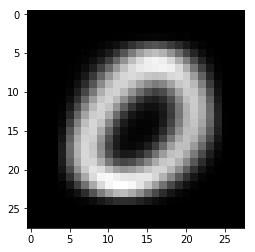

Label: 1


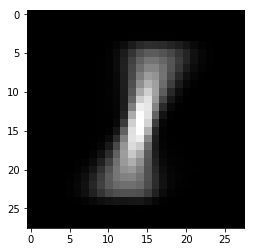

Label: 2


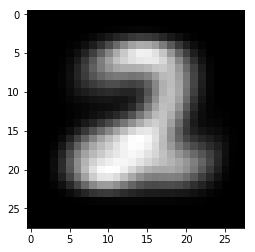

Label: 3


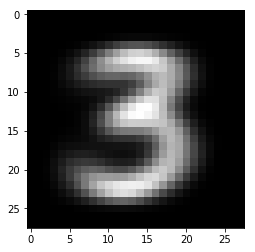

Label: 4


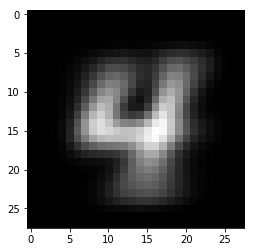

Label: 5


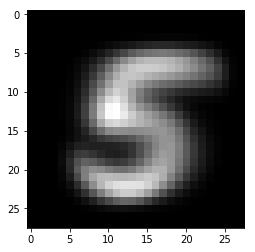

Label: 6


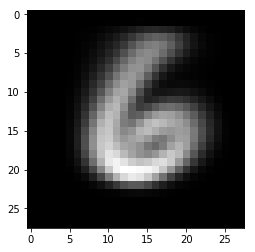

Label: 7


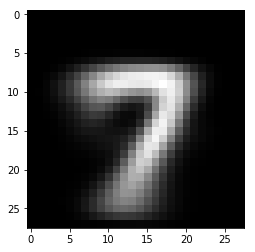

Label: 8


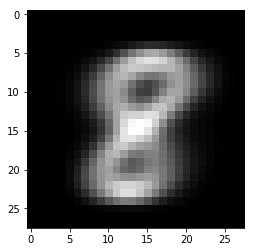

Label: 9


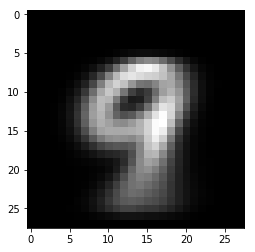

In [77]:
from scipy.stats import norm

def meanImage(train_set, train_labels):
    # return predicted labels of test set
    
    print("calculaing...")
    size = len(train_set[0])
    # index corresponding to each label 
    dict_train_index = {}
    # probability corresponding to each label
    probability = {}
    for i in range(0, 10):
        dict_train_index[i] = list(np.where(np.asarray(train_labels) == i)[0])
        probability[i] = len(dict_train_index[i])/len(train_labels)
        
#     dataset corresponding to each label
    dict_train_set = {}
    for i in range(0, 10):
        dict_train_set[i] = np.asarray([train_set[j] for j in dict_train_index[i]])  
    
#     mean and var for images' features
    mean_list = np.empty([10,size,size])
    var_list = np.empty([10,size,size])
    for i in range(0, 10):  
        for j in range(0, size):
            for k in range(0, size):
                feature_list = []
                for m in range(0, len(dict_train_set[i])):
                    feature_list.append(dict_train_set[i][m][j][k])
                feature_mean = np.mean(feature_list)
                mean_list[i][j][k] = feature_mean
                feature_var = np.var(feature_list)
                var_list[i][j][k] = feature_var
                
#    view mean image
    for i in range(0, 10):
        view_image(mean_list[i], i)
  

meanImage(t_x_train, y_train)
        
